# Plot TXx time series

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr

from utils import berkeley, era5, hadex3, utils

In [2]:
CLIMATOLOGY_PERIOD = slice("1961", "1990")

## Load ERA5 data

In [3]:
era5_txx_orig = era5.load_post(variable="txx").t2m
# era5_tnn_orig = era5.load_post(variable="tnn").t2m

era5_txx_orig = era5_txx_orig.set_index(time="year").rename(time="year")
era5_land_mask = era5.load_landmask()

In [4]:
era5_txx_land = utils.land_mean(era5_txx_orig, era5_land_mask > 0.5)
era5_txx_land = utils.calc_anomaly(era5_txx_land, CLIMATOLOGY_PERIOD)

## Load Berkeley Earth data

In [5]:
berkeley_txx_99_90_land_1961_1990 = berkeley.read_post(
    "txx", "99_90_land_1961_1990"
).txx

## Load HadEX3

> for HadEX3 the same methodology is used as in the [IPCC AR6 WGI Chapter 11, Figure 11.2](https://www.ipcc.ch/report/ar6/wg1/figures/chapter-11/figure-11-2/), see also [IPCC-WG1/Chapter-11/code/Figure_11.2_obs_ts_plots.ipynb](https://github.com/IPCC-WG1/Chapter-11/blob/main/code/Figure_11.2_obs_ts_plots.ipynb). 

In [6]:
# time period where data must be non-NaN
hadex_time_valid = slice("1961", None)

hadex_landmask = hadex3.HadEx3.read_landmask()


def hadex_calc_ave(dta, lat=None, minimum_valid=0.9):

    dta = dta.sel(time=hadex_time_valid)

    dta = hadex3.valid_for_globmean(dta, minimum_valid=minimum_valid)

    dta = dta if lat is None else dta.sel(lat=lat)

    dta = utils.land_mean(dta, hadex_landmask)

    return utils.calc_anomaly(dta, CLIMATOLOGY_PERIOD, dim="time")


HADEX_txx_map_orig = hadex3.HadEx3.read_file("TXx")
HADEX_txx = hadex_calc_ave(HADEX_txx_map_orig)

# for consistency
HADEX_txx = HADEX_txx.rename(time="year")

minimum_valid removed 11.52 % valid gridpoints


## Load offset

Computed offset of from 1961-1990 to 1850-1900 based on Berkeley Earth, see [BerkeleyEarth_process_data.ipynb](BerkeleyEarth_process_data.ipynb) for details.

In [7]:
berkeley_txx_offset = berkeley.read_post("txx", "offset_99_90_land_1961_1990").offset

## Figure

Only plot TXx for now, due to the differences in TNn which need to be understood first

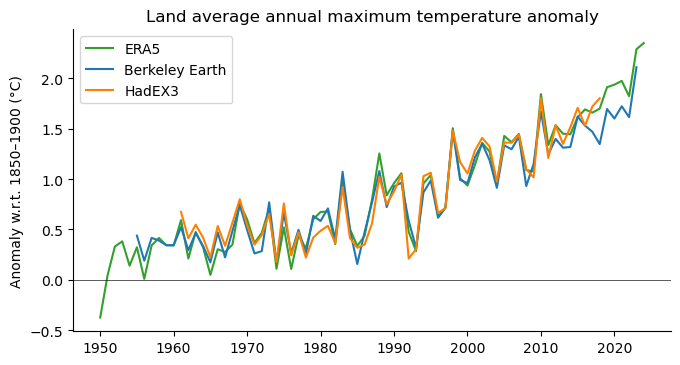

In [8]:
f, ax = plt.subplots(1, 1, layout="constrained", sharex=True, sharey=True)

f.set_size_inches(17 / 2.54, 9 / 2.54)

# plot ERA5
d = era5_txx_land + berkeley_txx_offset
d.plot(ax=ax, label="ERA5", color="#33a02c")

# plot Berkeley Earth
d = berkeley_txx_99_90_land_1961_1990 + berkeley_txx_offset
d.plot(ax=ax, label="Berkeley Earth", color="#1f78b4")

# plot HadEX3
d = HADEX_txx + berkeley_txx_offset
d.plot.line(ax=ax, label="HadEX3", color="#ff7f00")

# style plot

ax.legend()

ax.set_xlabel("")

ax.set_ylabel("Anomaly w.r.t. 1850–1900 (°C)")
ax.set_title("Land average annual maximum temperature anomaly")

ax.axhline(0, color="0.1", lw=0.5)

sns.despine(f)


plt.savefig(utils.fig_dir / "txx_ts_1961_1990_offset.png", dpi=300)
plt.savefig(utils.fig_dir / "txx_ts_1961_1990_offset.pdf", dpi=300)

## Write data

In [9]:
def ts_to_pandas(era5, berkeley, hadex):

    # set names
    era5.name = "ERA5"
    berkeley.name = "Berkeley"
    hadex.name = "HadEX3"

    txx = xr.merge([era5_txx_land, berkeley_txx_99_90_land_1961_1990, HADEX_txx])

    txx = txx.to_pandas()

    return txx


ds_txx = ts_to_pandas(era5_txx_land, berkeley_txx_99_90_land_1961_1990, HADEX_txx)

In [10]:
fN = "../data/txx_timeseries.csv"


HEADER = f"""\
Annual maximum land-mean temperatures (TXx) for
- ERA5
- Berkeley
- HadEX3

- units: °C
- land mean, no gap filling
- anomalies with respect to 1961-1990
- to obtain values relative to 1850-1900 please add offset
- offset: {berkeley_txx_offset.item():0.2f}°C

NOTE: using this data requires attributing the climate
      indicator project and the data providers. See
      https://github.com/ClimateIndicator/cip_extremes#data

"""


with open(fN, "w") as fid:

    fid.writelines(HEADER)
    ds_txx.to_csv(fid, na_rep="-", float_format="%.2f")

## Temporal means

Calculate averages for HadEX3 and ERA5

In [11]:
periods = (
    (2000, 2009),
    (2004, 2013),
    (2005, 2014),
    (2009, 2018),
    (2010, 2019),
    (2011, 2020),
    (2012, 2021),
    (2013, 2022),
    (2014, 2023),
    (2015, 2024),
)

out = dict()
for start, stop in periods:

    mn_hadex = ds_txx["HadEX3"].loc[slice(start, stop)].mean(skipna=False)
    mn_berkeley = ds_txx["Berkeley"].loc[slice(start, stop)].mean(skipna=False)
    mn_era5 = ds_txx["ERA5"].loc[slice(start, stop)].mean(skipna=False)

    key = f"{start}-{stop}"

    out[key] = [mn_hadex, mn_berkeley, mn_era5, mn_berkeley + berkeley_txx_offset.item(), mn_era5 + berkeley_txx_offset.item()]


df_decadal = pd.DataFrame.from_dict(out).T

mi = pd.MultiIndex.from_arrays(
    [("1961-1990", "1961-1990", "1961-1990", "1850-1900", "1850-1900"), ("HadEX3", "Berkeley Earth", "ERA5", "Berkeley Earth", "ERA5")]
)

df_decadal.columns = mi

df_decadal = df_decadal.round(2)

df_decadal.index.name = "Period"

df_decadal

1961-1990                           1850-1900      
             HadEX3 Berkeley Earth  ERA5 Berkeley Earth  ERA5
Period                                                       
2000-2009      0.72           0.66  0.69           1.18  1.21
2004-2013      0.80           0.75  0.84           1.27  1.35
2005-2014      0.86           0.80  0.89           1.31  1.40
2009-2018      1.01           0.89  1.02           1.41  1.54
2010-2019       NaN           0.95  1.11           1.46  1.62
2011-2020       NaN           0.94  1.12           1.45  1.63
2012-2021       NaN           0.99  1.18           1.50  1.69
2013-2022       NaN           1.01  1.21           1.52  1.72
2014-2023       NaN           1.09  1.29           1.60  1.81
2015-2024       NaN            NaN  1.38            NaN  1.90

In [12]:
fN = "../data/txx_decadal_means.csv"

df_decadal_out = df_decadal.copy(True)

# merge the multiindex columns for a nicer csv
mi = df_decadal_out.columns
mi = mi.reorder_levels([1, 0]).to_flat_index().str.join(" (") + ")"
df_decadal_out.columns = mi

df_decadal_out.to_csv(fN, na_rep="-", float_format="%.2f")

In [13]:
# output all periods for comparison with last year

print(df_decadal.to_csv(sep="\t", na_rep="-", float_format="%0.2f"))

	1961-1990	1961-1990	1961-1990	1850-1900	1850-1900
	HadEX3	Berkeley Earth	ERA5	Berkeley Earth	ERA5
Period					
2000-2009	0.72	0.66	0.69	1.18	1.21
2004-2013	0.80	0.75	0.84	1.27	1.35
2005-2014	0.86	0.80	0.89	1.31	1.40
2009-2018	1.01	0.89	1.02	1.41	1.54
2010-2019	-	0.95	1.11	1.46	1.62
2011-2020	-	0.94	1.12	1.45	1.63
2012-2021	-	0.99	1.18	1.50	1.69
2013-2022	-	1.01	1.21	1.52	1.72
2014-2023	-	1.09	1.29	1.60	1.81
2015-2024	-	-	1.38	-	1.90



In [14]:
# remove some periods 
# NOTE: paste as plain text (not HTML formatted) to a spreadsheet

print(
    df_decadal
    .drop(index=["2004-2013", "2010-2019", "2012-2021"])
    .to_csv(sep="\t", na_rep="-", float_format="%0.2f")
)

	1961-1990	1961-1990	1961-1990	1850-1900	1850-1900
	HadEX3	Berkeley Earth	ERA5	Berkeley Earth	ERA5
Period					
2000-2009	0.72	0.66	0.69	1.18	1.21
2005-2014	0.86	0.80	0.89	1.31	1.40
2009-2018	1.01	0.89	1.02	1.41	1.54
2011-2020	-	0.94	1.12	1.45	1.63
2013-2022	-	1.01	1.21	1.52	1.72
2014-2023	-	1.09	1.29	1.60	1.81
2015-2024	-	-	1.38	-	1.90

